In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import anndata as ad

In [2]:
import sys
sys.path.append('/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/git/veloUncertainty/veloUncertainty')
from countsplit import *
from v4_functions import *

In [3]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [ ]:
# We provide our estimated overdispersions for spliced and unspliced counts across the 27998 genes for simplicity of this tutorial
overdisp_S = np.array(pd.read_csv('/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/git/veloUncertainty/tutorial/pan_overdisp_S.csv')['x'])
overdisp_U = np.array(pd.read_csv('/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/yenchi-jerry_yuhong/git/veloUncertainty/tutorial/pan_overdisp_U.csv')['x'])

adata.var['spliced_overdisp'] = overdisp_S
adata.var['unspliced_overdisp'] = overdisp_S


In [5]:
# For this tutorial, just focus on the highly variable genes
hv_mask = adata.var['highly_variable_genes'] == 'True'
true_indices = adata.var.index[hv_mask]

adata = adata[:, hv_mask]

In [6]:
S_mat = adata.layers['spliced'].copy()
U_mat = adata.layers['unspliced'].copy()

In [7]:
def run_countsplit_with_overdispersion(S,U,split_seed,overdisp_S,overdisp_U):
    np.random.seed(split_seed)
    s1, s2  = countsplit(S,overdisps=overdisp_S)
    u1, u2  = countsplit(U,overdisps=overdisp_U)
    return [[s1,u1],[s2,u2]]


def create_adata_pancreas(S_split,U_split,adata_total):
    adata_split = ad.AnnData(X=S_split.astype(np.float32))
    adata_split.layers['spliced'] = S_split
    adata_split.layers['unspliced'] = U_split
    adata_split.uns = {'clusters_colors':adata.uns['clusters_colors'].copy()}
    adata_split.obsm['X_pcaOriginal'] = adata_total.obsm['X_pca'].copy()
    adata_split.obsm['X_umapOriginal'] = adata_total.obsm['X_umap'].copy()
    adata_split.obs = pd.DataFrame(index=adata_total.obs.index)
    for obs_col in adata_total.obs.columns:
        adata_split.obs[obs_col] = adata_total.obs[obs_col].copy()
    adata_split.var = pd.DataFrame(index=adata_total.var.index)
    for var_col in adata_total.var.columns:
        adata_split.var[var_col] = adata_total.var[var_col].copy()
    return adata_split


def countsplit_and_create_adata(S,U,total,split_seed,overdisp_S,overdisp_U):
    split1,split2 = run_countsplit_with_overdispersion(S=S,U=U,split_seed=split_seed,overdisp_S=overdisp_S,overdisp_U=overdisp_U)
    adata1 = create_adata_pancreas(split1[0],split1[1],total)
    adata2 = create_adata_pancreas(split2[0],split2[1],total)
    return adata1,adata2


In [8]:
adata_split1,adata_split2 = countsplit_and_create_adata(S=S_mat,
                                                        U=U_mat,
                                                        total=adata,
                                                        split_seed=10,
                                                        overdisp_S=adata.var['spliced_overdisp'],
                                                        overdisp_U=adata.var['unspliced_overdisp'])


In [9]:
adata_split1

AnnData object with n_obs × n_vars = 3696 × 4004
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes', 'spliced_overdisp', 'unspliced_overdisp'
    uns: 'clusters_colors'
    obsm: 'X_pcaOriginal', 'X_umapOriginal'
    layers: 'spliced', 'unspliced'

In [10]:
# In this tutorial, run scVelo in the 'stochastic' mode so it's fast 
def scv_compute_velocity(adata):
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=30, n_pcs=40)
    scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
    sc.tl.umap(adata)
    scv.tl.velocity(adata)
    scv.tl.velocity_graph(adata)
        

In [11]:
scv_compute_velocity(adata)
scv_compute_velocity(adata_split1)
scv_compute_velocity(adata_split2)

Filtered out 2282 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)
or disable the progress bar using `show_progress_bar=False`.


/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Filtered out 2834 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Filtered out 2805 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [12]:
# emulating the plot_cosine_similarity_withRef function
cos_sim, Ngene = compute_cosine_similarity_union(adata_split1=adata_split1,
                                                 adata_split2=adata_split2,
                                                 method='scv')

Size of the union of genes for velocity computation in splits = 1273


In [13]:
adata.obs['cos_sim'] = cos_sim
celltype_label = 'clusters'

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:6

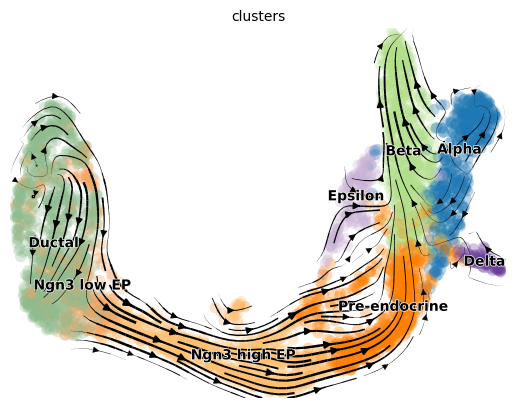

In [14]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

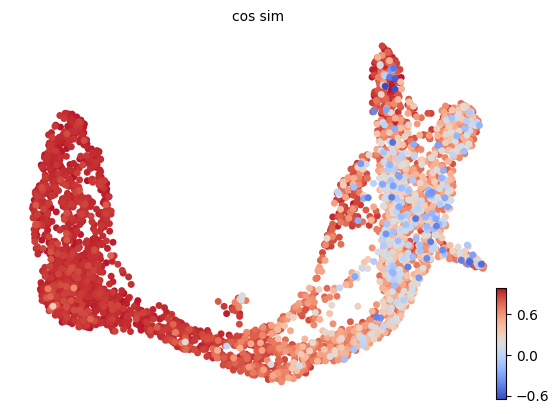

In [ ]:
# Sort so high values come first, low values last (so they appear on top)
adata_sorted = adata[adata.obs['cos_sim'].sort_values(ascending=False).index, :]

scv.pl.scatter(adata_sorted,
               color='cos_sim',
               cmap='coolwarm',
               size=100,
               sort_order=False)